***Ex. 1.*** Arătaţi echivalenţa dată în exemplul de la pagina 15 a cursului 3. Mai precis, arătaţi că dacă $A$, $B$, şi $C$ sunt variabile aleatoare discrete, atunci

$$
A \perp C \mid B
$$

Show that if $A$, $B$, and $C$ are discrete random variables, then:

$$
A \perp C \mid B
$$

dacă şi numai dacă există două funcţii pozitive $phi_{A,B}$, $phi_{B,C}$, şi o constantă de normalizare $k > 0$ astfel încât:

$$
P(A = x_A, B = x_B, C = x_C) = \frac{1}{k} \cdot \phi_{A,B}(x_A, x_B) \cdot \phi_{B,C}(x_B, x_C), \quad \forall x_A, x_B, x_C.
$$

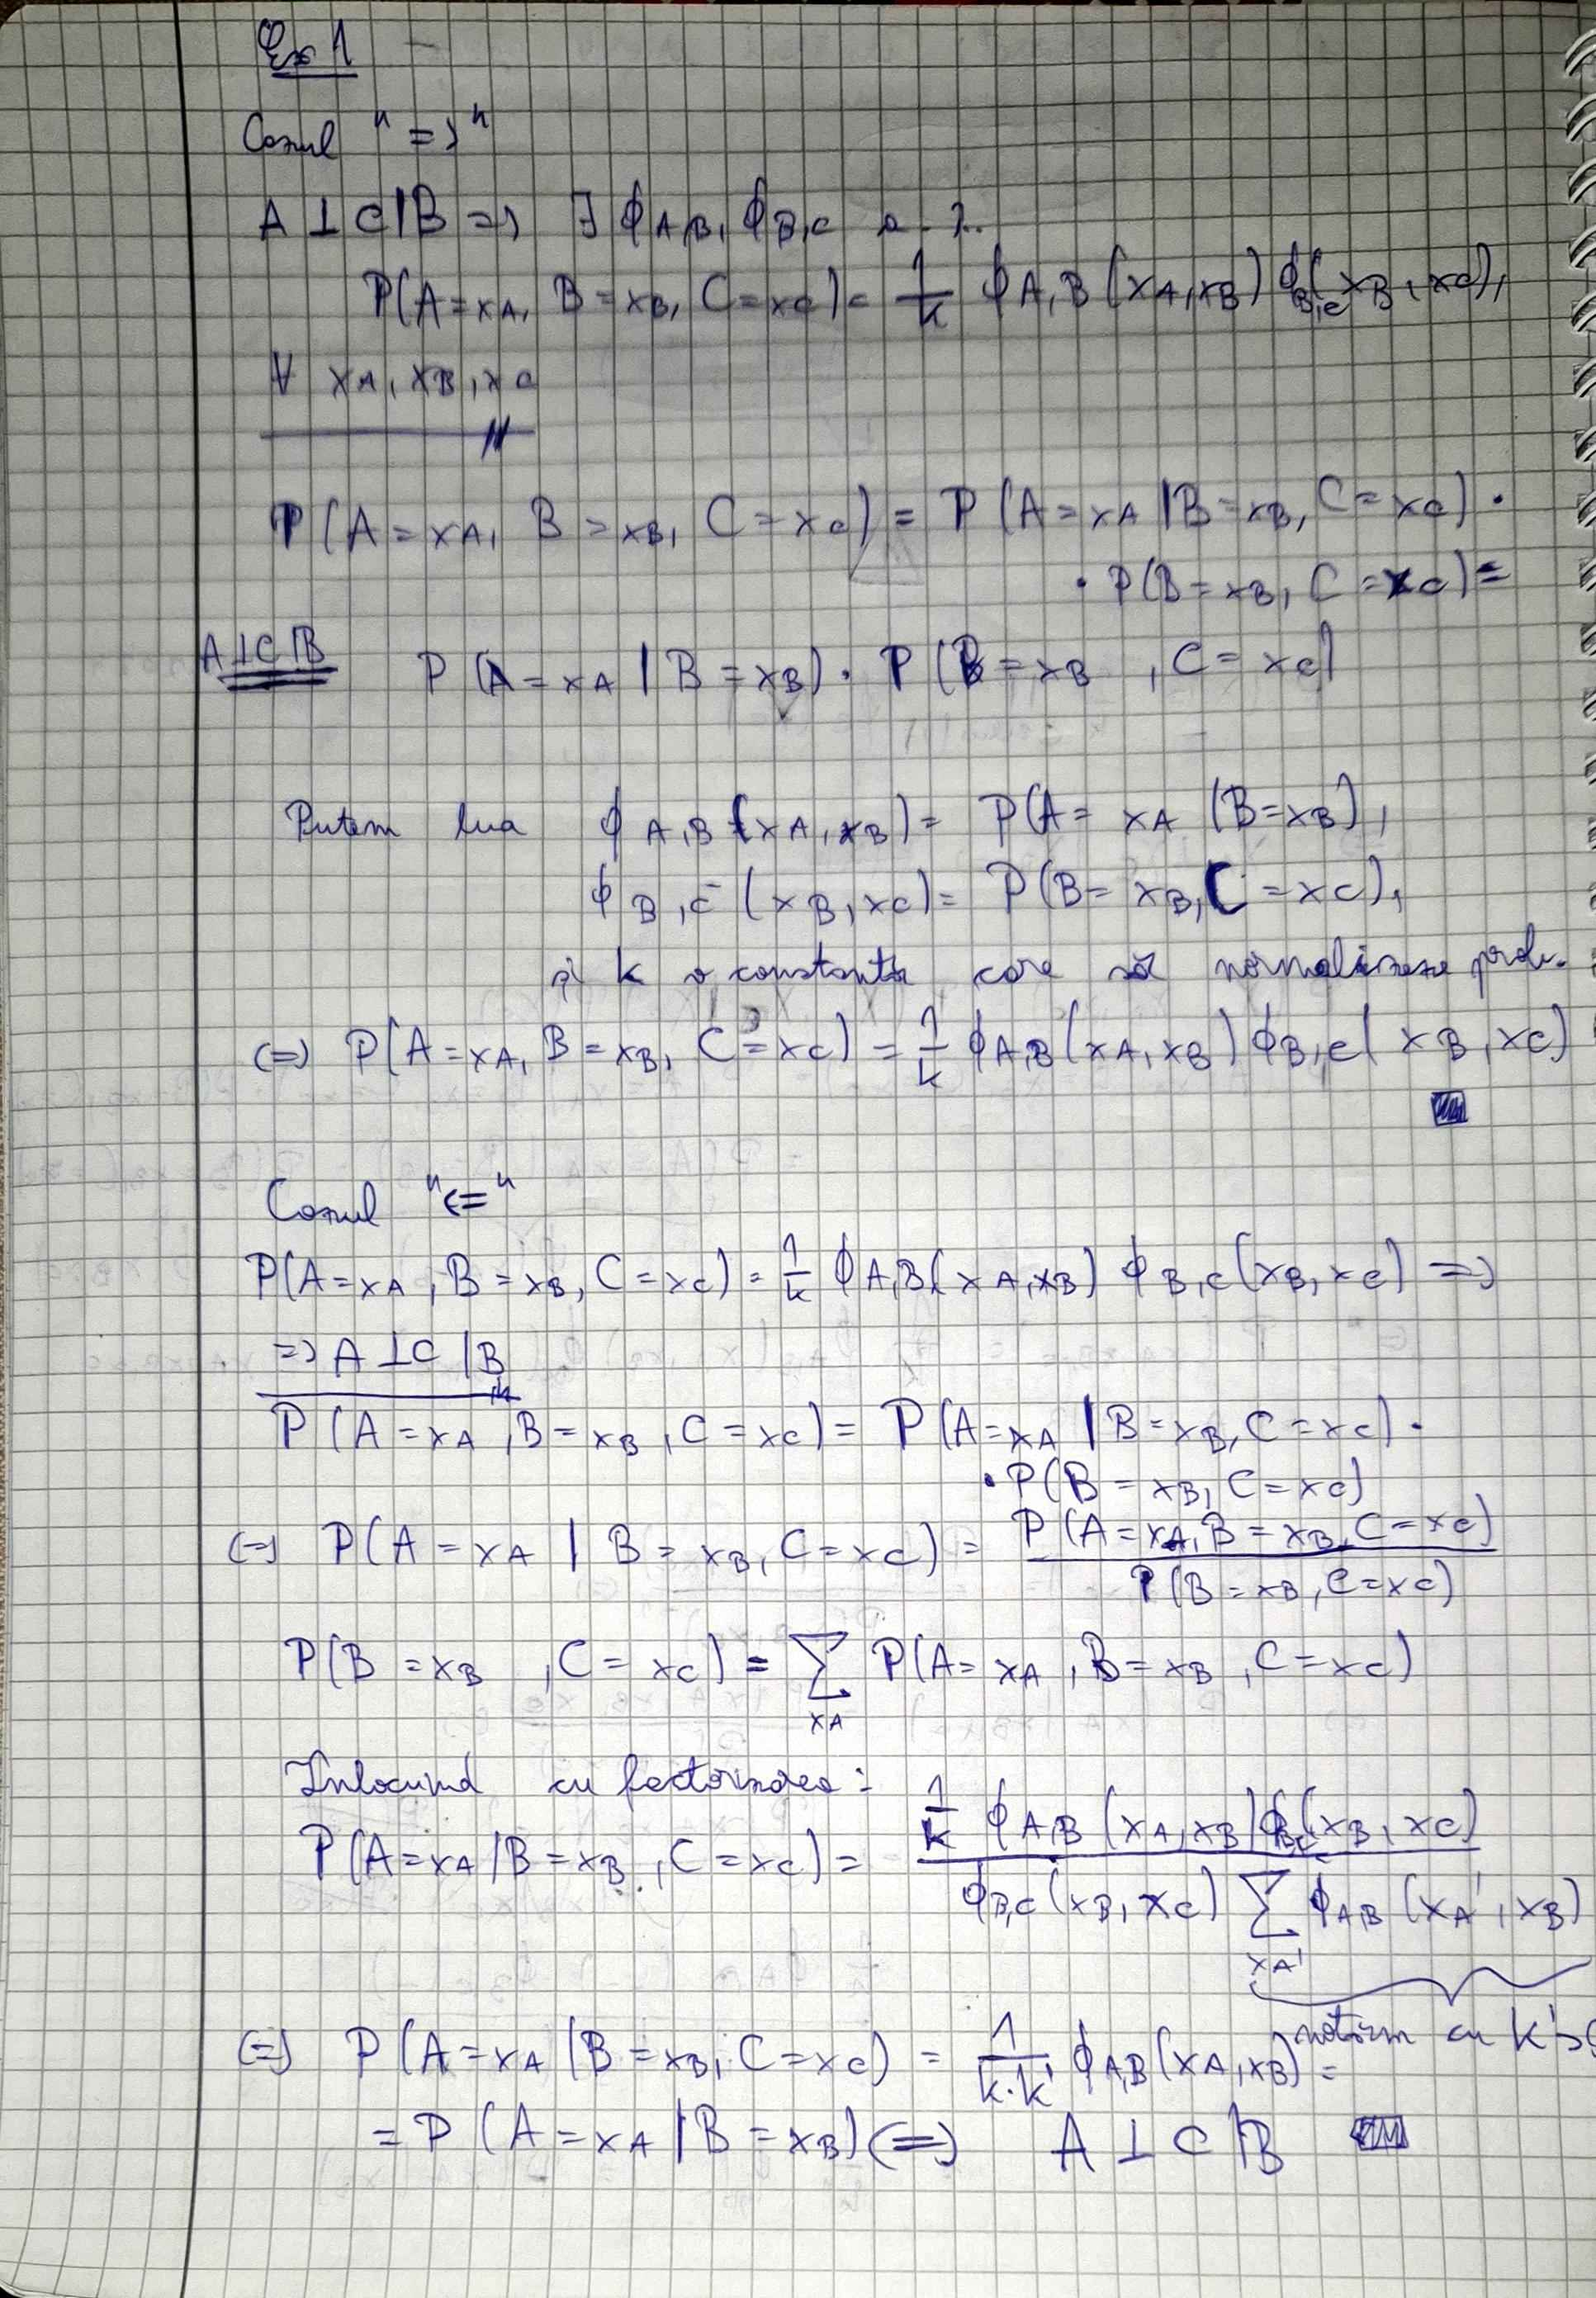

In [1]:
from IPython.display import Image

Image("1.jpg")

***Ex. 2.*** Considerăm o regiune în care observăm vremea la mai multe staţii meteo, S1, S2, . . . , Sn. Fiecare staţie raportează
una dintre cele trei stări: „Soare”, „Ploaie” sau „Nori”. Vrem să prezicem starea vremii la fiecare staţie meteo, luând în
considerare dependenţele dintre staţiile adiacente. Considerăm că vremea la o staţie depinde direct de vremea la staţiile
vecine.
Vom folosi o reţea Markoviană pentru a modela vremea la mai multe locaţii şi vom inferea asupra vremii la o staţie
necunoscută, pe baza datelor de la vecini.

Date de intrare (introduse de către utilizator):
● numărul de staţii meteo, n;

● muchiile corespunzătoare reţelei Markoviene, adică vecinii fiecărei staţii. Pentru simplitate, vom presupune că
reţeaua este aciclică, adică nu există clici de dimensiune 3;

● probabilităţile iniţiale pentru fiecare staţie (exemplu: P(S) = 0.5, P(P) = 0.3, P(N) = 0.2).

Folosind pgmpy, definiţi o reţea Markoviană pentru problema de mai sus, unde potenţialul pentru fiecare pereche de
staţii vecine (adiacente) este dat de matricea:
[0.7 0.2 0.1]
[0.2 0.6 0.2]
[0.1 0.3 0.6]


In [2]:
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
import networkx as nx
import re
import numpy as np

def create_edges(n, S):
    #pentru a lista S, returnam lista de tuple [(S1, S2), (S2, S3), ..., (Sn-1, Sn)]
    edges = [(S[0], S[1])]
    for i in range(1, n-1):
        edges.append((S[i], S[i+1]))
    
    return edges
    
def weather_station_MRF(n, edges, initial_probabilities):
    model = MarkovNetwork()

    for i in range(n):
        node = 'S_' + str(i+1)
        model.add_node(node)

    for edge in edges:
        model.add_edge(edge[0], edge[1])

    potential_matrix = np.array([[0.7, 0.2, 0.1],
                             [0.2, 0.6, 0.2],
                             [0.1, 0.3, 0.6]])  

    for edge in edges:
        factor = DiscreteFactor(variables=edge, cardinality=[3, 3], values = potential_matrix.flatten())
        model.add_factors(factor)\
        
    for i in range(n):
        factor = DiscreteFactor(variables=['S_'+str(i+1)], cardinality=[3], values=initial_probabilities)
        model.add_factors(factor)

    pos = nx.circular_layout(model)
    nx.draw(model, with_labels=True, pos=pos, alpha=0.5, node_size=2000)
    return model

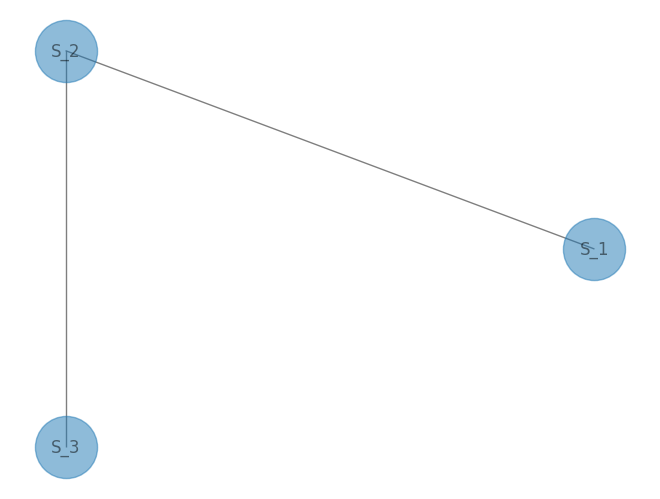

In [6]:
def parse_edges_string():
    string = input("Introduceti muchii sub format \"(i, j), (l, k)\": ")
    matches = re.findall(r'\((\d+),\s*(\d+)\)', string)
    if matches:
        return [("S_" + a, "S_" + b) for a, b in matches]
    else:
        print("Muchiile au fost introduse incorect! Introdu din nou:")
        return parse_edges_string()
    
def parse_probabilities():
    prob_S = float(input("Introduceti P(S): "))
    prob_P = float(input("Introduceti P(P): "))
    prob_N = float(input("Introduceti P(N): "))
    probabilities = [prob_S, prob_P, prob_N]

    if sum(probabilities) != 1:
        print("Probabilitati imposibile (au suma diferita de 1)! Introdu din nou: ")
        return parse_probabilities()
    elif prob_S < 0 or prob_P < 0 or prob_N < 0 or prob_S > 1 or prob_P > 1 or prob_N > 1:
        print("Probabilitati imposibile (cel putin una nu este in interval [0,1])! Introdu din nou: ")
        return parse_probabilities()
    
    return probabilities

def input_information():
    n = int(input("Introduceti n: "))
    edges = parse_edges_string()
    probabilities = parse_probabilities()

    return (n, edges, probabilities)

information = input_information()
model = weather_station_MRF(information[0], information[1], information[2])

In [7]:
model.get_local_independencies()

(S_1 ⟂ S_3 | S_2)
(S_3 ⟂ S_1 | S_2)

Folosiţi metoda Maximum A Posteriori (MAP) pentru a prezice starea vremii la fiecare staţie meteo (în pgmpy, puteţi apela funcţiile BeliefPropagation şi map_query).

In [8]:
from pgmpy.inference import BeliefPropagation

stations = []
for i in range(0, information[0]):
    stations.append('S_' + str(i+1))

bp_infer = BeliefPropagation(model)
marginals = bp_infer.map_query(variables=stations)
print(marginals)

{'S_1': 2, 'S_2': 2, 'S_3': 2}


***Ex. 3.*** O problemă clasică care poate fi rezolvată folosind Markov Random Fields (MRF) este cea a denoising-ului imaginii, unde obiectivul este de a curăţa o imagine cu zgomot (noise) prin estimarea valorii fiecărui pixel, bazându-ne pe vecinii săi.

In [10]:
import numpy as np

# Creăm o imagine de 5x5 cu valori binare (0 sau 1)
original_image = np.random.randint(0, 2, (5, 5))
print("Imaginea originală:\n", original_image)


Imaginea originală:
 [[1 1 1 1 0]
 [1 0 0 0 1]
 [0 0 1 0 0]
 [1 0 1 1 0]
 [1 1 1 0 1]]


In [13]:
#copiem imaginea originală
noisy_image = original_image.copy()

#adaugam zgomit
num_noisy_pixels = int(0.1 * original_image.size)
noisy_indices = np.random.choice(original_image.size, num_noisy_pixels, replace=False)

#modificăm pixelii selectați (inversăm valorile 0 -> 1, 1 -> 0)
for index in noisy_indices:
    x, y = divmod(index, original_image.shape[1])
    noisy_image[x, y] = 1 - noisy_image[x, y]

print("Imaginea cu zgomot:\n", noisy_image)


Imaginea cu zgomot:
 [[0 1 1 1 0]
 [1 0 0 0 1]
 [0 0 1 0 0]
 [1 0 1 1 0]
 [1 1 1 1 1]]


In [14]:
from pgmpy.models import MarkovModel
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation

height, width = original_image.shape
model = MarkovNetwork()

for i in range(height):
    for j in range(width):
        model.add_node((i, j))

#adăugăm muchii pentru fiecare pereche de pixeli vecini (N, S, E, W):
for i in range(height):
    for j in range(width):
        if i > 0:
            model.add_edge((i, j), (i-1, j))  # Nord
        if i < height - 1:
            model.add_edge((i, j), (i+1, j))  # Sud
        if j > 0:
            model.add_edge((i, j), (i, j-1))  # Vest
        if j < width - 1:
            model.add_edge((i, j), (i, j+1))  # Est

lambda_val = 1.0
for (i, j), (ni, nj) in model.edges():
    factor = DiscreteFactor([(i, j), (ni, nj)], [2, 2], [1, lambda_val, lambda_val, 1])
    model.add_factors(factor)


In [16]:
from pgmpy.inference import BeliefPropagation

noisy_pixel_indices = [(i, j) for i in range(height) for j in range(width) if noisy_image[i, j] != original_image[i, j]]

#definim observările doar pentru pixelii zgomotoși
evidence = {coord: noisy_image[coord[0], coord[1]] for coord in noisy_pixel_indices}

#lista tuturor variabilelor din imagine (fiecare pixel)
variables = [(i, j) for i in range(height) for j in range(width)]
unknown_variables = [var for var in variables if var not in evidence]

bp = BeliefPropagation(model)
map_estimate = bp.map_query(variables=unknown_variables, evidence=evidence)

#convertim rezultatul într-o imagine, folosind atât estimările MAP, cât și valorile din evidență
denoised_image = np.zeros((height, width), dtype=int)
for i in range(height):
    for j in range(width):
        if (i, j) in map_estimate:
            denoised_image[i, j] = map_estimate[(i, j)]
        else:
            denoised_image[i, j] = noisy_image[i, j]

print("Imaginea denoisată (estimare MAP):\n", denoised_image)


Imaginea denoisată (estimare MAP):
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]
